In [33]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import cv2

from matplotlib import pyplot as plt

from skimage.segmentation import active_contour # For active_contour function
from skimage.segmentation import morphological_geodesic_active_contour
import skimage
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage import io, filters, color, morphology, segmentation, measure, feature, img_as_ubyte
from scipy import ndimage as ndi


from skimage import draw
from PIL import Image

import os

In [80]:
def calc_dist(p1, p2):
    '''
    Calculates the euclidean distance between two points.
    
    Args:
    - p1 (tuple): Point 1 (y1, x1).
    - p2 (tuple): Point 2 (y2, x2).
    
    Return:
    - The euclidean distance.
    '''
    return np.sqrt(((p1[0] - p2[0]) ** 2) + ((p1[1] - p2[1]) ** 2))


def remove_hair(img):
    #Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA) l
    
    return np.array(dst)  

def crop_img(img, threshold=100):
    '''
    Crop the image to get the region of interest. Remove the vignette frame.
    Analyze the value of the pixels in the diagonal of the image, from 0,0 to h,w and
    take the points where this value crosses the threshold by the first time and for last.

    Args:
    - img (numpy ndarray): Image to crop.
    - threshold (int): Value to split the diagonal into image and frame.

    Return:
    - The coordinates of the rectangle and the cropped image.
    '''
    # Get the image dimensions
    h, w = img.shape[:2]

    # Get the coordinates of the pixels in the diagonal
    y_coords = ([i for i in range(0, h, 3)], [i for i in range(h - 3, -1, -3)])
    x_coords = ([i for i in range(0, w, 4)], [i for i in range(0, w, 4)])

    # Get the mean value of the pixels in the diagonal, form 0,0 to h,w 
    # and from h,0 to 0,w
    coordinates = {'y1_1': 0, 'x1_1': 0, 'y2_1': h, 'x2_1': w, 'y1_2': h, 'x1_2': 0, 'y2_2': 0, 'x2_2': w}
    for i in range(2):
        d = []
        y1_aux, x1_aux = 0, 0
        y2_aux, x2_aux = h, w 
        for y, x in zip(y_coords[i], x_coords[i]):
            d.append(np.mean(img[y, x, :]))

        # Get the location of the first point where the threshold is crossed
        for idx, value in enumerate(d):
            if value >= threshold:
                coordinates['y1_' + str(i + 1)] = y_coords[i][idx]
                coordinates['x1_' + str(i + 1)] = x_coords[i][idx]
                break

        # Get the location of the last point where the threshold is crossed
        for idx, value in enumerate(reversed(d)):
            if value >= threshold:
                coordinates['y2_' + str(i + 1)] = y_coords[i][-idx if idx != 0 else -1]
                coordinates['x2_' + str(i + 1)] = x_coords[i][-idx if idx != 0 else -1]
                break

    # Set the coordinates to crop the image
    y1 = max(coordinates['y1_1'], coordinates['y2_2'])
    y2 = min(coordinates['y2_1'], coordinates['y1_2'])
    x1 = max(coordinates['x1_1'], coordinates['x1_2'])
    x2 = min(coordinates['x2_1'], coordinates['x2_2'])
    
    return y1, y2, x1, x2, img[y1:y2, x1:x2, :]



def thresholding(img):
    '''
    Converts the image to HSV and compute an otsu thresholding over the saturation channel
    
    Args:
    - img (numpy ndarray): Image to apply the threshold.
    
    Return:
    - The mask generated by the threshold.
    '''
    img = filters.gaussian(img, sigma=3)
    # Convert the image to HSV and get only the saturation channel
    image_hsv = color.rgb2hsv(img)[:, :, 1]

    # Compute an otsu thresholding over the saturation channel
    otsu_th = filters.threshold_otsu(image_hsv)
    predicted_mask = (image_hsv > otsu_th).astype(int)

    #if predicted_mask[predicted_mask.shape[0]//2,predicted_mask.shape[1]//2] == 0:
    #    predicted_mask = np.ones_like(predicted_mask)-predicted_mask
    #return predicted_mask,otsu_th
    #return predicted_mask,1
    mask = ndi.binary_fill_holes(predicted_mask)
    selem = morphology.disk(4)   #12
    mask = morphology.erosion(mask, selem)
    mask = morphology.dilation(mask, selem)
# Label the mask to get the properties of the regions 
    label_img = measure.label(mask)
    regions = measure.regionprops(label_img)

# Compute the distance between each region centroid and the center of the image and get the closest one
    dist = [(props.label, calc_dist(props.centroid, tuple(ti / 2 for ti in mask.shape[:2]))) for props in regions]
    dist = sorted(dist, key=lambda tup: tup[1])

    aux = dist[0][0]

    label_img[label_img != aux] = 0
    label_img[label_img == aux] = 1
    mask = label_img 

    # Enlarges the mask and makes it more polygonal
    #mask = morphology.dilation(mask, morphology.disk(10))
    #mask = morphology.convex_hull_image(mask, offset_coordinates=True)

    return mask, otsu_th



def define_initial_circle(R0,r0,c0,Nber_pts=400):
    # Define initial contour shape
    s      = np.linspace(0, 2*np.pi, Nber_pts)
    Radius = R0
    r      = r0 + Radius*np.sin(s)
    c      = c0 + Radius*np.cos(s) #col
    init   = np.array([r, c]).T
    return init

def segmentation_snake(img):
    height,width,_ = img.shape 

    img_to_seg=img; r0 = height//2 ; c0= width//2 ; R0 = (height+width)//7
    init = define_initial_circle(R0,r0,c0)

    Niter_smooth    = 7
    img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)
    alpha_val  = 0.01 ; beta_val = 1 ;gamma_val = 0.01; convergence_val = 1e-4;Niter_snake = 800;

    snake_max = active_contour(img_to_seg,
                init, max_num_iter=Niter_snake, convergence=convergence_val,
                alpha=alpha_val, beta=beta_val, gamma=gamma_val)
    
    mask = np.zeros((img.shape[0],img.shape[1]), dtype=np.uint8)
    rr, cc = draw.polygon(snake_max[:, 0], snake_max[:, 1], mask.shape)
    mask[rr, cc] = 255
    mask = mask.astype(np.float32)
    return mask



def get_features(image, binary_mask): 

    binary_mask.astype(np.float32)
    masked_img = np.zeros_like(image)
    masked_img[binary_mask != 0] = image[binary_mask != 0]      # Attention


    labelled_mask = measure.label(binary_mask)

    # Compute region properties, including area, for each labeled region
    props = measure.regionprops(labelled_mask)
    #print(len(props))



    contours = measure.find_contours(binary_mask, 0.5)
    # Get the largest contour (assuming it represents the object)
    #largest_contour = max(contours, key=len)

    # Get the centroid of the object
    centroid = props[0].centroid
    perimeter = props[0].perimeter


    # 1] ASYMMETRY
    area_total = props[0].area
    img_mask = props[0].image

    horizontal_flip = np.fliplr(img_mask)
    diff_horizontal = img_mask * ~horizontal_flip

    vertical_flip = np.flipud(img_mask)
    diff_vertical = img_mask * ~vertical_flip

    diff_horizontal_area = np.count_nonzero(diff_horizontal)
    diff_vertical_area = np.count_nonzero(diff_vertical)
    asymm_idx = 0.5 * ((diff_horizontal_area / area_total) + (diff_vertical_area / area_total))
    ecc = props[0].eccentricity


    # 2] Border 
    Compatness = (perimeter**2)/(4*np.pi*area_total)

    # 3] Color variegation:
    sliced = image[props[0].slice]
    lesion_r = sliced[:, :, 0]
    lesion_g = sliced[:, :, 1]
    lesion_b = sliced[:, :, 2]

    C_r = np.std(lesion_r) / np.max(lesion_r)
    C_g = np.std(lesion_g) / np.max(lesion_g)
    C_b = np.std(lesion_b) / np.max(lesion_b)
        
    # 4] Diameter:
    eq_diameter = props[0].equivalent_diameter

    # 5] Texture:
    gray_img = color.rgb2gray(image)
    glcm = feature.graycomatrix(image=img_as_ubyte(gray_img), distances=[1],
                                angles=[0, np.pi/4, np.pi/2, np.pi * 3/2],
                                symmetric=True, normed=True)

    correlation = np.mean(feature.graycoprops(glcm, prop='correlation'))
    homogeneity = np.mean(feature.graycoprops(glcm, prop='homogeneity'))
    energy = np.mean(feature.graycoprops(glcm, prop='energy'))
    contrast = np.mean(feature.graycoprops(glcm, prop='contrast'))

    
    return [asymm_idx, ecc, Compatness, C_r, C_g, C_b,eq_diameter, correlation, homogeneity, energy, contrast]



In [35]:
def process_images_and_features(folder):
    data = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(folder, filename)
            segmentation_path = os.path.join(folder, filename[:-4] + "_seg.png")  # Assuming segmentation file follows the "_seg.png" pattern
            
            if os.path.isfile(segmentation_path):
                # Load the image and segmentation mask
                image = Image.open(image_path)
                image = np.array(image)
                segmentation_mask = Image.open(segmentation_path)
                segmentation_mask = np.array(segmentation_mask)
                
                features = get_features(image,segmentation_mask)
                features.insert(0, filename)
                data.append(features)
                         
            else: 
                image = Image.open(image_path)
                image = np.array(image)
                image = remove_hair(image)
                _,_,_,_,image = crop_img(image, threshold=20)
                try: 
                    mask,_ = thresholding(image)
                    features = get_features(image,mask)
                    features.insert(0, filename)
                    data.append(features)
                except Exception as e:
                    print(f"Error processing {filename}: {e}")
    
    columns = ["ID"] + [f"Feature_{i}" for i in range(1, len(data[0]))]
    df = pd.DataFrame(data, columns=columns)
    
    # Save DataFrame to a CSV file
    df.to_csv("Test_features.csv", index=False)

    

In [88]:
process_images_and_features("Test")

/var/folders/l2/z2gsclc533x1y1kdjc0_55hr0000gn/T/ipykernel_26972/3572759513.py:214: RuntimeWarning: invalid value encountered in scalar divide
  C_b = np.std(lesion_b) / np.max(lesion_b)
/var/folders/l2/z2gsclc533x1y1kdjc0_55hr0000gn/T/ipykernel_26972/3572759513.py:212: RuntimeWarning: invalid value encountered in scalar divide
  C_r = np.std(lesion_r) / np.max(lesion_r)
/var/folders/l2/z2gsclc533x1y1kdjc0_55hr0000gn/T/ipykernel_26972/3572759513.py:213: RuntimeWarning: invalid value encountered in scalar divide
  C_g = np.std(lesion_g) / np.max(lesion_g)


## Un exemple de cas où la ségmentation ne s'est pas bien passée :

(512, 512, 3)
(353, 364, 3)


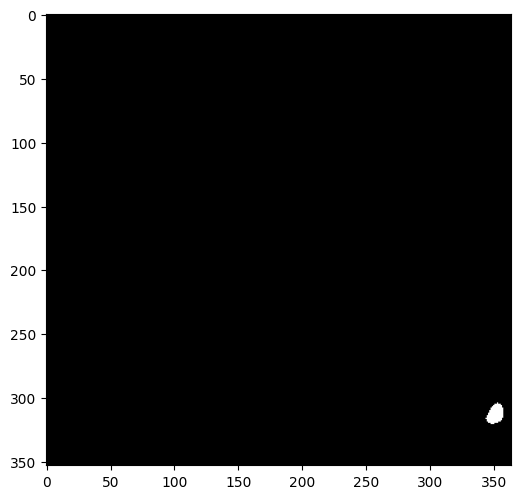

In [84]:
image = Image.open('Train/ISIC_0072512.jpg')
image = np.array(image)
image = remove_hair(image)
print(image.shape)
_,_,_,_,image = crop_img(image, threshold=10)
print(image.shape)
      
mask,_ = thresholding(image)
features = get_features(image,mask)

fig, ax = plt.subplots(figsize=(6, 6));
ax.imshow(mask,cmap=plt.cm.gray)